In [1]:
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import nltk
import re
from nltk.corpus import stopwords 
from collections import Counter
import string
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)


In [2]:
path_ = "IMDB Dataset.csv"
data = pd.read_csv(path_)
print(data)

                                                  review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]


In [3]:
# spliting to train and test data
X,y = data['review'].values,data['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (750,)
shape of test data is (250,)


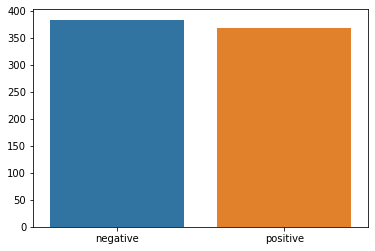

In [4]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

In [5]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)
    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sentence in x_train:
        for word in sentence.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_train,final_test = [],[]
    for sentence in x_train:
            final_train.append([onehot_dict[preprocess_string(word)] for word in sentence.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sentence in x_val:
            final_test.append([onehot_dict[preprocess_string(word)] for word in sentence.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_train), np.array(encoded_train),np.array(final_test), np.array(encoded_test),onehot_dict

In [6]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)         
print(f'Length of vocabulary is {len(vocab)}')

print('Train Set')
print(x_train, '\n')
print(x_test, '\n')

Length of vocabulary is 1000
Train Set
[list([58, 126, 22, 244, 358, 10, 13, 2, 22, 847, 61, 135, 954, 90, 334, 263, 563, 142, 36, 804, 901, 66, 383, 21, 18, 40, 142, 349, 608, 715, 334, 534, 10, 1, 10, 103, 11, 137, 955, 466, 956, 103, 12, 21, 10, 756, 367, 13, 104, 493, 130, 3])
 list([805, 957, 806, 220, 368, 283, 586, 369, 152, 53, 564, 384, 114, 185, 177, 467, 34, 30, 67, 284, 535, 39, 77, 385, 5, 12, 902, 227, 319, 95, 1, 335, 634])
 list([85, 28, 72, 105, 418, 96, 757, 1, 85, 250, 37, 11, 50, 19, 419, 52, 49, 185, 455, 1, 85, 93, 106, 63, 79, 96, 72, 183, 146, 320, 63, 115, 100, 85, 28, 16, 506, 37, 71, 197, 50, 1, 903, 60])
 list([3, 136, 66, 635, 245, 147, 468, 27, 1, 1, 456, 115, 58, 38, 457, 45, 7, 106, 148, 1, 16, 758, 312, 758, 49, 66, 402, 1, 958, 107, 244, 233, 91, 17, 264, 321, 264, 58, 159, 386, 57, 536, 1, 13, 140])
 list([403, 96, 676, 387, 3, 116, 404, 676, 455, 1, 677, 14, 52, 759, 75, 12, 285, 420, 636, 11, 336, 35, 1, 163, 47, 265, 251, 716, 1, 8, 507, 41, 11, 13

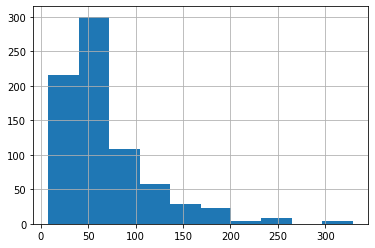

count    750.000000
mean      68.902667
std       47.927235
min        8.000000
25%       38.250000
50%       54.000000
75%       83.750000
max      329.000000
dtype: float64

In [7]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [8]:
# padding
def padding_sent(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for i, review in enumerate(sentences):
        if len(review) != 0:
            features[i, -len(review):] = np.array(review)[:seq_len]

    return features       

x_train_padded = padding_sent(x_train,500)
x_test_padded = padding_sent(x_test,500)  

In [9]:
# create tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_padded), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_padded), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size,drop_last=True)

In [10]:
########### MODEL ###########
class SentimentLSTM(nn.Module):
    def __init__(self, num_layers, vocab_size, output_dim, hidden_dim, embedding_dim, drop_prob=0.5):
        super(SentimentLSTM, self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.vocab_size = vocab_size

        # embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # lstm layer
        self.rnn = nn.RNN(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=num_layers, batch_first=True)
        #dropout layer
        self.dropout = nn.Dropout(0.3)
        #linear layer
        self.linear = nn.Linear(self.hidden_dim, self.output_dim)
        self.sig = nn.Sigmoid()

    def forward(self, x, hidden):
        batch_size = x.size(0)
        embeds = self.embedding(x)

        rnn_out, hidden = self.rnn(embeds, hidden)
        rnn_out = rnn_out.contiguous().view(-1, self.hidden_dim)
    
        out = self.dropout(rnn_out)
        out = self.linear(out)

        sigm_out = self.sig(out)
        # reshape to be batch_size first
        sigm_out = sigm_out.view(batch_size, -1)
        # get last batch of labels
        sigm_out = sigm_out[:, -1]

        return sigm_out, hidden

    def init_hidden(self, batch_size):
        # initializing "previous" hidden state
        hidden = torch.zeros((self.num_layers,batch_size,self.hidden_dim)).to(device)
        #c0 = torch.zeros((self.num_layers,batch_size,self.hidden_dim)).to(device)
        return hidden     

In [11]:
num_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256       
model = SentimentLSTM(num_layers,vocab_size,output_dim,hidden_dim,embedding_dim,drop_prob=0.5)

In [12]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

model.to(device)

GPU not available, CPU used


SentimentLSTM(
  (embedding): Embedding(1001, 64)
  (rnn): RNN(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [13]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

clip = 5
epochs = 10 
valid_loss_min = np.Inf
#store results
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

In [14]:
for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    
    for inputs, labels in train_loader:
        h = model.init_hidden(batch_size)
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        #h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            #val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), './resultsRNN.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')    

Epoch 1
train_loss : 0.7034942944844563 val_loss : 0.740862762928009
train_accuracy : 51.733333333333334 val_accuracy : 48.4
Validation loss decreased (inf --> 0.740863).  Saving...
Epoch 2
train_loss : 0.5959709227085114 val_loss : 0.8476249575614929
train_accuracy : 69.06666666666666 val_accuracy : 49.2


KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show() 